# Overview
Here, we develop a new metrics for the sharpness of a chess position. We define a position as sharp if a human player is likely to make a mistake. More precisely, our measure is the expected centi-pawn loss in a given position.

This expected loss is obtained from a supervised learning model that is trained on data from both professional and amateur players. To train this model, we extract a number of features that describe each position, for instance the position of the king and the number of pieces on the board, and then use these features to predict the centipawn loss in human play.

Our initial results suggest that the results are plausible. Positions that are estimated to be very sharp do appear highly sharp in our (admittedly subjective) human evaluation.

## Comparison to previous research
Existing research (Guid and Bratko, 2006) has proposed a measure that is based on the change in evaluation as an engine's depth increases. This measure has the advantage that it is very easy to obtain when running computer evaluations.

As we have time, we aim to compare our new metric to the metric proposed in the previous research.

In [182]:
# Ignoring warnings here. This is ok because I do the real development in an ipython shell where
# I see all warnings.
import warnings
warnings.filterwarnings('ignore')

In [192]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
import pandas.io.sql as sqlio
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

import chess
import chess.svg
from IPython.display import SVG

In [184]:
import queries
import functions as f
import imp
imp.reload(queries); imp.reload(f);

In [185]:
pd.set_option('precision', 2)
pd.set_option('display.width', 200)
pd.set_option('max_colwidth',90)

use_dev = False
connstring = f.CONNSTRING_DEV if use_dev else f.CONNSTRING_PROD

conn = psycopg2.connect(connstring)
params = {
  'move_number_start': 20
, 'move_number_end': 40
}

# Loading the raw data

In [186]:
df = sqlio.read_sql_query(queries.q_positions, conn)
len(df)

1912900

In [187]:
df_games = sqlio.read_sql_query(queries.q_games, conn).rename(columns={'id': 'game_id'})
df_db = sqlio.read_sql_query(queries.q_db, conn).rename(columns={'id': 'database_id'})
df_players = sqlio.read_sql_query(queries.q_players, conn).rename(columns={'id': 'player_id'})
df_tournaments = sqlio.read_sql_query(queries.q_tournaments, conn).rename(columns={'id': 'tournament'})

# Cleaning the data

In [155]:
cols_per_position = ['game_id', 'move_number', 'is_white', 'fen', 'eval_played', 'eval_best', 'result']
wide = df.drop_duplicates().set_index(cols_per_position + ["typ"]).unstack(level=-1)
colnames = [v for (k, v) in f.names.items()]
wide.columns = colnames
wide = wide.reset_index()
wide = wide.sort_values(['game_id', 'move_number', 'is_white'], ascending=[True, True, False])
wide['cploss'] = f.top_and_bottom(wide.eval_best - wide.eval_played, 0, 300)
time_range = range(0, 5)
for t in time_range:
  wide['cploss_t%s' % t] = wide.groupby('game_id').cploss.shift(-t)
wide.columns
wide['cploss_avg'] = wide[['cploss_t%s' % s for s in time_range]].mean(axis=1)
wide['number_takes_opp_lag'] = wide.groupby(['game_id', 'is_white']).number_takes_opp.shift(1)

wide = wide[wide.cploss_avg.notnull()]
wide = wide[wide.cploss.notnull()]
wide = wide.query('20 <= move_number <= 40')
wide['decisive'] = (wide.result != 0).astype(int)
wide['const'] = 1

distinct_games = df_games.groupby('pgn').first().reset_index().game_id
wide = wide[wide.game_id.isin(distinct_games)]

# Preparing for the regressions

## Covariates

covars = ['const'] + colnames + ['number_takes_opp_lag']
covars

## Splitting data into training and test sample

In [190]:
num = int(len(wide) * 0.7)
wide_train = wide[:num]
wide_test = wide[num:].copy()
X = wide_train[covars].astype(float)
y = wide_train.cploss_avg
X_test = wide_test[covars].astype(float)

## Summary stats for the features

In [191]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
const,21311.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
number_moves_own,21311.0,32.64,10.41,1.0,27.0,34.0,40.0,62.0
number_moves_opp,21311.0,32.99,11.47,0.0,27.0,35.0,41.0,63.0
number_checks_own,21311.0,0.92,1.26,0.0,0.0,1.0,1.0,12.0
number_checks_opp,21311.0,0.94,1.24,0.0,0.0,1.0,1.0,14.0
number_takes_own,21311.0,2.25,1.58,0.0,1.0,2.0,3.0,10.0
number_takes_opp,21311.0,2.32,1.64,0.0,1.0,2.0,3.0,11.0
number_takes_pawn_own,21311.0,0.17,0.43,0.0,0.0,0.0,0.0,4.0
number_takes_pawn_opp,21311.0,0.17,0.44,0.0,0.0,0.0,0.0,8.0
opp_kings,21311.0,0.16,0.37,0.0,0.0,0.0,0.0,1.0


## Linear regression model
To understand the impact of the features, we estimate a linear regression model.

Some of the variables do strongly enter in the expected direction. For instance, a smaller pawn shield in front of the king (`kings_pawn_own`) is associated with a sharper position.

For future predictions, we do not use this model. Instead, we continue with the random forest model that we estimate next.

In [193]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cploss_avg   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     68.99
Date:                Thu, 30 Aug 2018   Prob (F-statistic):          3.15e-284
Time:                        16:47:08   Log-Likelihood:                -90683.
No. Observations:               21311   AIC:                         1.814e+05
Df Residuals:                   21289   BIC:                         1.816e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.8996      0.922     10.733      0.000       8.092      11.708
number_moves_own          0.0060      0.020      0.298      0.766      -0.034       0.046
number_moves_opp         -0.0597      0.021     -2.814      0.005      -0.101      -0.018
number_checks_own         1.2453      0.108     11.572      0.000       1.034       1.456
number_checks_opp         1.0060      0.109      9.254      0.000       0.793       1.219
number_takes_own          0.4164      0.098      4.266      0.000       0.225       0.608
number_takes_opp          0.6356      0.113      5.614      0.000       0.414       0.858
number_takes_pawn_own     0.1298      0.429      0.302      0.762      -0.711       0.971
number_takes_pawn_opp    -0.1321      0.418     -0.316      0.752      -0.951       0.687
opp_kings                -0.7349      0.342     -2.150      0.032      -1.405      -0.065
piece_values_own          0.3579      0.106      3.390      0.001       0.151       0.565
piece_values_opp         -0.3126      0.107     -2.922      0.003      -0.522      -0.103
kings_pawn_own           -1.4505      0.144    -10.101      0.000      -1.732      -1.169
kings_pawn_opp           -1.6256      0.143    -11.348      0.000      -1.906      -1.345
king_row_own              0.2912      0.197      1.480      0.139      -0.095       0.677
king_row_opp              0.1040      0.193      0.538      0.591      -0.275       0.483
queens_own                3.3166      1.098      3.020      0.003       1.164       5.469
queens_opp                1.1260      1.101      1.023      0.307      -1.032       3.284
rooks_own                 0.2004      0.424      0.472      0.637      -0.632       1.032
rooks_opp                 0.9763      0.427      2.285      0.022       0.139       1.814
in_check                  4.4862      0.937      4.788      0.000       2.650       6.323
number_takes_opp_lag      0.0547      0.098      0.560      0.575      -0.137       0.246
==============================================================================
Omnibus:                    22043.012   Durbin-Watson:                   0.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2050511.939
Skew:                           5.059   Prob(JB):                         0.00
Kurtosis:                      49.977   Cond. No.                         783.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Random forest model

In [194]:
reg = RandomForestRegressor(n_estimators=50, random_state=0)
reg.fit(X, y)
wide_test['y_pred'] = reg.predict(X_test)
wide_test = wide_test.sort_values('y_pred', ascending=False)
wide['y_pred'] = reg.predict(wide[covars])

In [195]:
def fen_to_svg(fen):
    board = chess.Board(fen[4:])
    return SVG(chess.svg.board(board=board, size=200)) 

df_validate = wide_test.query('piece_values_own >= 30')[['game_id', 'y_pred', 'fen', 'piece_values_own']]

# Validation
We start by looking at the top-10 sharpest positions. In this position, the predicted centipawn loss is above 100!

In [196]:
df_sharp = df_validate.groupby('game_id').first().reset_index().sort_values('y_pred', ascending=False)
df_sharp.head(10)

,game_id,y_pred,fen,piece_values_own
45,3704,136.36,fen 3r1b1r/1P1q1p2/1Q6/2pk2P1/3n2b1/4R1Pp/P1PP1P2/R1B3K1 b - - 5 28,31
16,3457,105.95,fen 2Q1k2r/pp1b2b1/4q3/2p2pn1/5pnp/4B3/PP1QB2P/3RKNR1 b k - 1 25,32
93,3788,78.16,fen 2r3kr/3n4/pp1pN1p1/3Bn1Pp/P3Q3/7R/1P1q3P/5R1K b - - 3 36,30
27,3483,65.29,fen 2r3kr/1b1q2p1/pB2NbBn/1p1N3p/2p5/Pn5P/1P2QPP1/3RR1K1 b - - 1 28,36
63,3734,63.18,fen 2b1k3/4rp1p/p1n3r1/2Nq4/1p3Q2/5NPP/PP3P2/2R2K1R w - - 2 24,30
32,3494,58.61,fen 3b1rk1/5q2/p2p4/P1pNp1p1/1p1pP1P1/1P1P1r1p/2P1Q2P/R4RK1 b - - 1 29,30
2,3429,53.93,fen 1r4k1/b3nrp1/7p/p7/4Q1Bq/P3P2P/1P1B1P2/R2R1K2 w - - 3 29,30
150,3896,51.32,fen r1bq1r2/p5bk/4B3/3pp1p1/2pN1P2/2Bn2P1/PP1Q4/R4RK1 b - f3 1 25,33
69,3749,50.83,fen 3qr3/r2n3k/p5p1/1pNBPpB1/1PnP3p/7Q/5P2/R2R2K1 b - - 1 31,30
148,3893,50.72,fen 5r1k/1p5r/p1b3R1/n1q1pP2/P1p2p1P/N1P2P1B/1P2Q2K/3R4 w - - 4 34,31


## Sharp positions

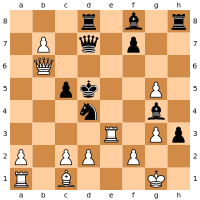

In [197]:
fen_to_svg(df_sharp.fen.iloc[0])

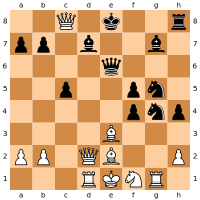

In [198]:
fen_to_svg(df_sharp.fen.iloc[1])

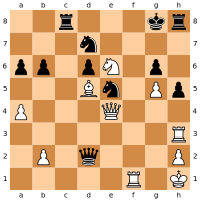

In [199]:
fen_to_svg(df_sharp.fen.iloc[2])

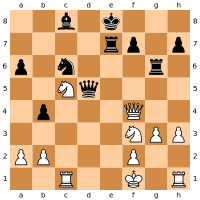

In [200]:
fen_to_svg(df_sharp.fen.iloc[4])

## Calm positions

In [201]:
df_calm = df_validate.groupby('game_id').last().reset_index().reset_index().sort_values('y_pred', ascending=True)
df_calm.head(10)

,index,game_id,y_pred,fen,piece_values_own
17,17,3459,4.93,fen 2rqr1k1/pb3pp1/1p2p2p/7n/3PP3/1B3N1P/P4PPQ/3RR1K1 w - - 1 21,31
37,37,3693,5.37,fen r4rk1/1pn1qpp1/p3p2p/P3P3/1n2Q2P/5NP1/1P3PB1/R4RK1 b - - 1 23,31
124,124,3837,5.38,fen 1r1q2k1/1p1rbpp1/p3p1p1/P2n4/3P2P1/1Q2PB1P/1R1B1PK1/1R6 w - - 2 25,31
101,101,3801,5.44,fen r2r2k1/ppp1b1pp/3q4/5p2/2PPb3/1P1N4/1P3BPP/R2QR1K1 w - - 2 21,31
120,120,3831,5.52,fen 1r1r2k1/pp1b1p2/4pqpp/3P1n2/P1P1Q3/3B1N2/5PPP/R3R1K1 b - - 1 21,31
28,28,3486,5.61,fen 2r2r1k/1b2q1pp/p2p4/2n1p3/2P1P3/4BN1P/5PP1/2RQR1K1 w - - 1 25,30
140,140,3863,5.96,fen 1rr3k1/5pb1/2pn2p1/p1Np1bqp/N2P4/P3P3/4BPPP/2RQ1R1K b - - 1 22,34
44,44,3703,5.96,fen 1r3rk1/2q2pp1/3bn2p/1Bp1p3/Pp2Q2P/3P1NP1/1P3P2/1R2R1K1 b - - 2 34,31
62,62,3733,5.98,fen 1r3rk1/Qpbq1pp1/2p1pnp1/8/2PP3P/2N3P1/PP3P2/R1BR2K1 w - - 1 20,32
55,55,3722,5.98,fen 2r3k1/pb1rbp1p/4q1p1/2pp3n/8/1P2P1P1/PB1NQPBP/2RR2K1 b - - 6 25,34


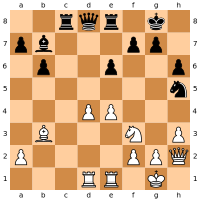

In [202]:
fen_to_svg(df_calm.fen.iloc[0])

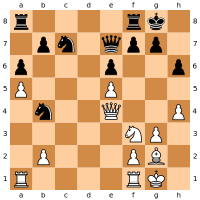

In [203]:
fen_to_svg(df_calm.fen.iloc[1])

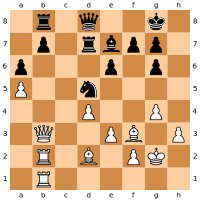

In [204]:
fen_to_svg(df_calm.fen.iloc[2])

# Detailed analysis from Candidates tournaments

In [205]:
cols_wide = ['game_id', 'y_pred', 'is_white', 'move_number']
cols_games = ['game_id', 'player_white_id', 'player_black_id', 'database_id', 'date', 'tournament']
cols_players = ['player_id', 'first_name', 'last_name']
cols_tournaments = ['tournament', 'name']
wm = wide[cols_wide].merge(df_games[cols_games], on='game_id')
wm['player_id'] = wm.player_white_id * wm.is_white + wm.player_black_id * (1 - wm.is_white)
wm = wm.merge(df_players[cols_players], on='player_id')
wm = wm.merge(df_tournaments[cols_tournaments].rename(columns={'name':'tournament_name'}), on='tournament')
wm = wm.merge(df_db[['database_id', 'name']], on='database_id')
wm['date_python'] = pd.to_datetime(wm.date)
wm['year'] = wm.date_python.dt.year
wm[['date', 'date_python']].sample(20)
wm.name.unique()

array(['World Championships 1886-2014', 'Candidates 2011-2018',
       'Wijk An Zee (Tata Steel) 2012-2018', 'Rejkjavik Open 2018',
       'Supertournaments 2017'], dtype=object)

## How sharply do the players play?

In [206]:
wm = wm[wm.name == "Candidates 2011-2018"]

group = 'last_name'
mean = pd.DataFrame(wm.groupby(group).y_pred.mean())
mean.columns = ['average_sharpness']
mean['number_positions'] = wm.groupby(group).y_pred.count()
mean['number_games'] = wm.groupby(group).game_id.nunique()
mean.query('number_positions >= 100').sort_values('average_sharpness')

,average_sharpness,number_positions,number_games
last_name,,,
So,11.83,217,13
Mamedyarov,12.23,236,14
Caruana,14.03,216,12
Karjakin,14.66,225,14
Kramnik,14.67,263,15
Aronian,15.71,218,13
Ding,16.63,200,11
Grischuk,18.10,209,12


## Identifying the sharpest and calmest games

In [207]:
game_means = pd.DataFrame(wm.groupby(['tournament_name', 'game_id', 'player_white_id', 'player_black_id']).y_pred.mean().sort_values(ascending=False))
game_means['n_moves'] = wm.groupby(['tournament_name', 'game_id', 'player_white_id', 'player_black_id']).y_pred.count()
game_means = game_means.reset_index()
player_names = df_players[['player_id', 'last_name']]
game_means = game_means.merge(player_names.rename(columns={'last_name':'name_white'}), left_on='player_white_id', right_on='player_id')
game_means = game_means.merge(player_names.rename(columns={'last_name':'name_black'}), left_on='player_black_id', right_on='player_id')
game_means = game_means.query('n_moves >= 20').sort_values('y_pred', ascending=False)

cols = ['tournament_name', 'game_id', 'name_white', 'name_black', 'y_pred']

## The sharpest games

In [208]:
game_means[cols].head(10)

,tournament_name,game_id,name_white,name_black,y_pred
1,FIDE Candidates 2018,3476,Karjakin,Kramnik,32.72
8,FIDE Candidates 2018,3457,Aronian,Grischuk,32.10
10,FIDE Candidates 2018,3483,Ding,Grischuk,28.68
35,FIDE Candidates 2018,3454,Grischuk,Ding,28.41
49,FIDE Candidates 2018,3445,Grischuk,So,22.53
19,FIDE Candidates 2018,3449,Caruana,Mamedyarov,22.41
42,FIDE Candidates 2018,3492,Caruana,Aronian,21.59
28,FIDE Candidates 2018,3487,Karjakin,Caruana,21.12
37,FIDE Candidates 2018,3468,Kramnik,Ding,18.80
15,FIDE Candidates 2014,3501,Aronian,Mamedyarov,18.57


## The calmest games

In [209]:
game_means[cols].tail(10)

,tournament_name,game_id,name_white,name_black,y_pred
6,FIDE Candidates 2018,3463,Mamedyarov,Kramnik,9.19
26,FIDE Candidates 2018,3471,Mamedyarov,Karjakin,8.85
7,FIDE Candidates 2018,3459,So,Kramnik,8.67
36,FIDE Candidates 2018,3474,Caruana,Ding,8.55
27,FIDE Candidates 2018,3491,So,Karjakin,8.48
4,FIDE Candidates 2018,3481,Caruana,Kramnik,7.98
21,FIDE Candidates 2018,3484,So,Mamedyarov,7.92
48,FIDE Candidates 2018,3479,Ding,So,7.84
14,FIDE Candidates 2018,3473,So,Grischuk,7.76
24,FIDE Candidates 2018,3458,Caruana,Karjakin,7.40
